# PREDICTING STUDENT PERFORMANCE IN EXAMS USING REGRESSION ALGORITHMS

This dataset consists of data related to students of a particular grade and their scores in Maths, Reading and Writing specified out of 100. I will be using various regression algorithms to predict math score by using the features available in the dataset.

# VARIABLE DESCRIPTIONS:

1) gender: specifies gender of the student(male/female)

2) race: specifies race of the student(group A,group B,group C)

3) parental level of education: specifies highest educational qualification of any parent of each student

4) lunch_type: standard/reduced,the type of lunch package selected for the student

5) test_prep: specifies if the test preparation course was completed by the student or not

6) math_score: specifies score in math(our target variable)

7) reading_score: specifies score in reading

8) writing_score: specifies score in writing

All scores are taken out of 100.

In [1]:
import numpy as np
from numpy import random
random.seed(12345)

In [2]:
from sklearn import metrics
from sklearn.metrics import r2_score
import sklearn

In [3]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'png'
sns.set()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go
from scipy.stats import chi2_contingency
from sklearn.linear_model import Ridge

init_notebook_mode(connected=True)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/students-performance-in-exams/StudentsPerformance.csv


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score

In [6]:
%config InlineBackend.figure_format = 'retina'

In [7]:
data=pd.read_csv("/kaggle/input/students-performance-in-exams/StudentsPerformance.csv")
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


Dataset has zero null values with 8 columns and 1000 rows.

In [9]:
data.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


In [10]:
data.columns.unique()

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')

**Renaming Columns**

In [11]:
columns1={'gender':'gender','race/ethnicity':'race','parental level of education':'parent_ed_level','lunch':'lunch_type','test preparation course':'test_prep','math score':'math','reading score':'reading','writing score':'writing'}
data.rename(columns=columns1,inplace=True)

In [12]:
data.head()

,gender,race,parent_ed_level,lunch_type,test_prep,math,reading,writing
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


**Data Wrangling**

In [13]:
data['total']=data['math']+data['reading']+data['writing']

In [14]:
data['parent_ed_level'].unique()

array(["bachelor's degree", 'some college', "master's degree",
       "associate's degree", 'high school', 'some high school'],
      dtype=object)

As we can see "some high school" and "high school" represent the same level of education, we can replace the former with a single value namely "high school".

In [15]:
data['parent_ed_level']=data['parent_ed_level'].replace(['some high school'],'high school')
data['parent_ed_level'].unique()

array(["bachelor's degree", 'some college', "master's degree",
       "associate's degree", 'high school'], dtype=object)

In [16]:
data['lunch_type']=data['lunch_type'].replace(['free/reduced'],'reduced')

In [17]:
data.head()

,gender,race,parent_ed_level,lunch_type,test_prep,math,reading,writing,total
0,female,group B,bachelor's degree,standard,none,72,72,74,218
1,female,group C,some college,standard,completed,69,90,88,247
2,female,group B,master's degree,standard,none,90,95,93,278
3,male,group A,associate's degree,reduced,none,47,57,44,148
4,male,group C,some college,standard,none,76,78,75,229


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   gender           1000 non-null   object
 1   race             1000 non-null   object
 2   parent_ed_level  1000 non-null   object
 3   lunch_type       1000 non-null   object
 4   test_prep        1000 non-null   object
 5   math             1000 non-null   int64 
 6   reading          1000 non-null   int64 
 7   writing          1000 non-null   int64 
 8   total            1000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


**VISUAL DATA ANALYSIS**

# UNIVARIATE ANALYSIS

In this we look at one feature at a time. Finding out the distribution of that feature while ignoring other features is usually done here.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7febdc45a910>,
      dtype=object)

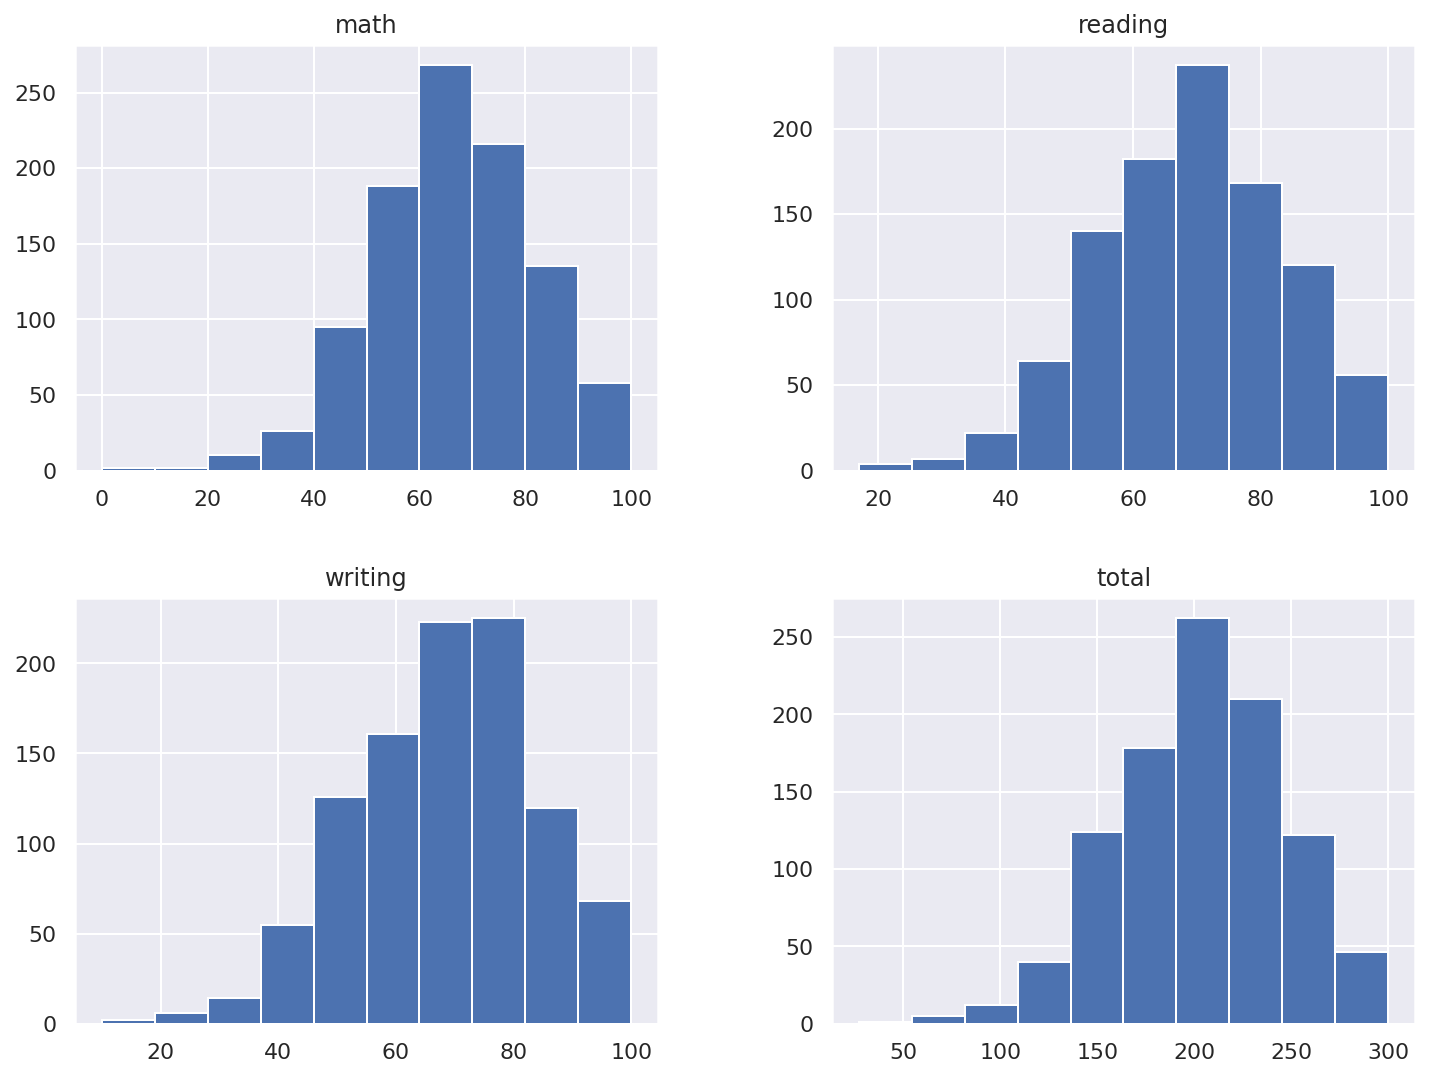

In [19]:
data[['math','reading','writing','total']].hist(figsize=(12,9))

Every distribution plotted above is Left-Skewed.

BOXPLOTS

In [20]:
#function to create a boxplot
def boxplot(column,dataf):
    plt.figure(figsize=(10,4))
    sns.boxplot(x=column,data=dataf)

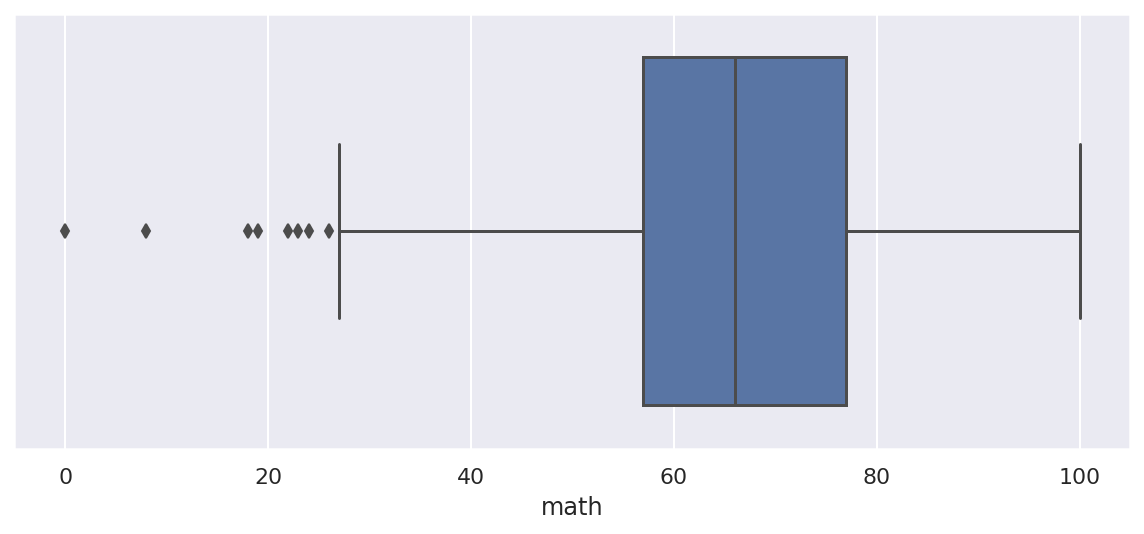

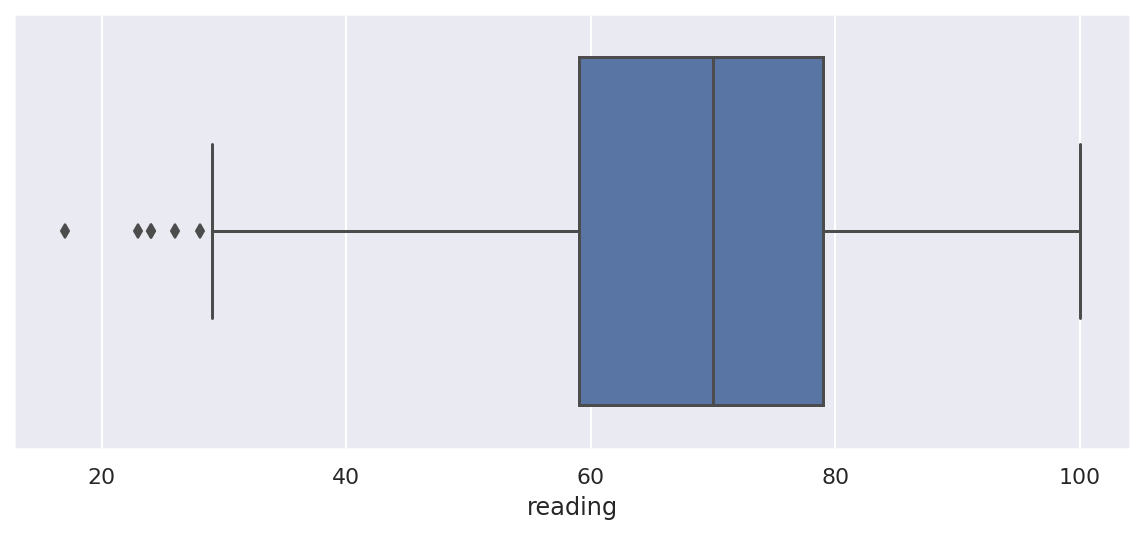

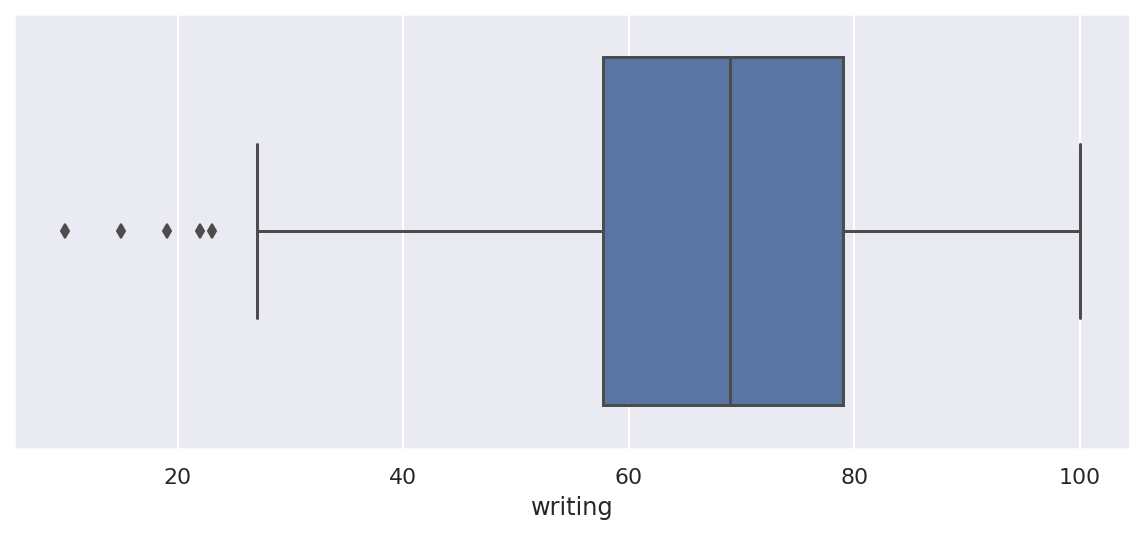

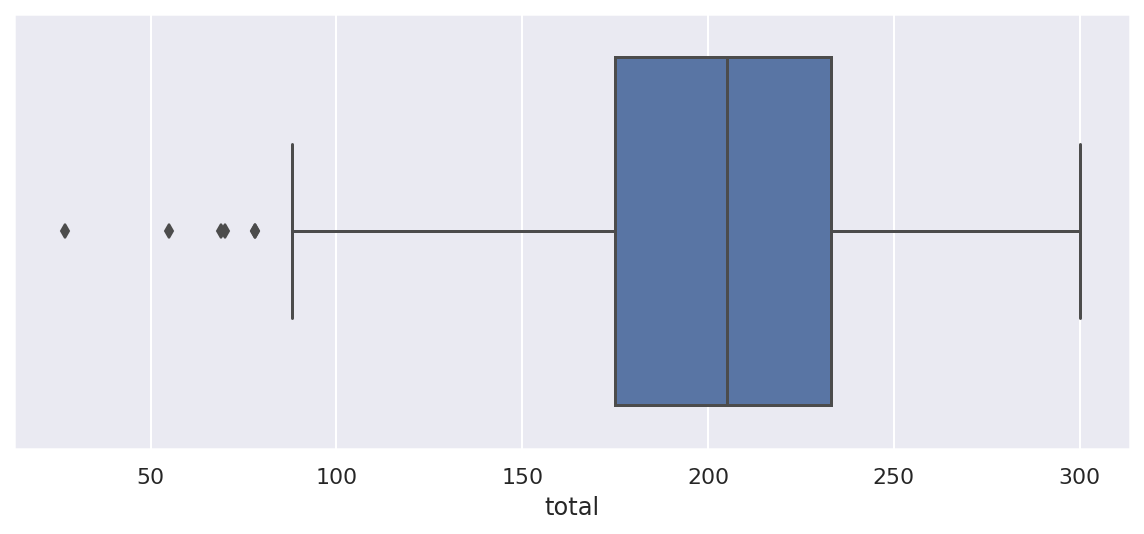

In [21]:
nums=['math','reading','writing','total']
for i in nums:
    boxplot(i,data)

#Interpreting boxplots

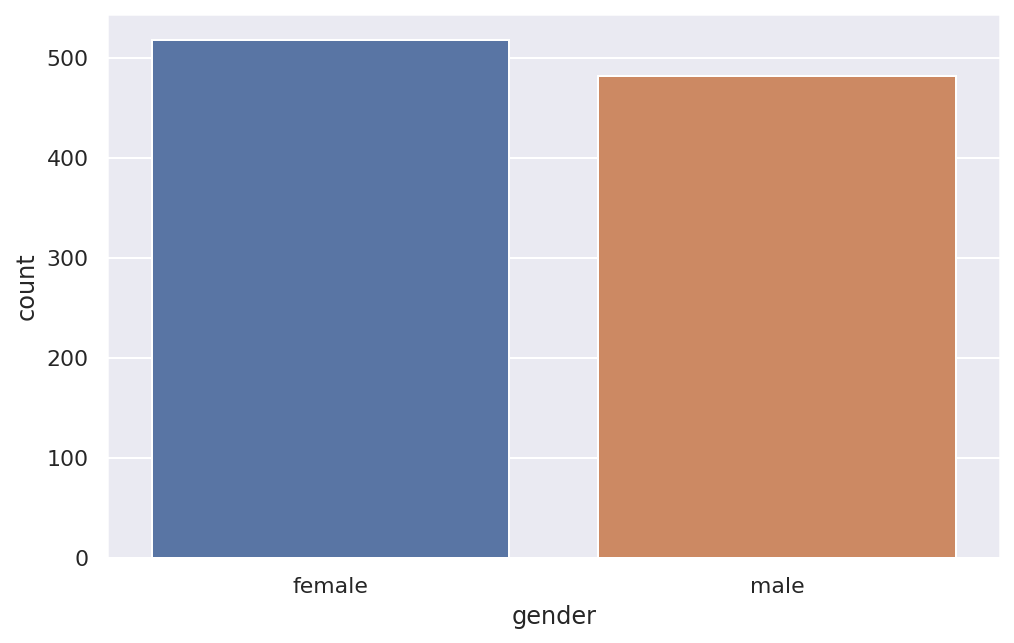

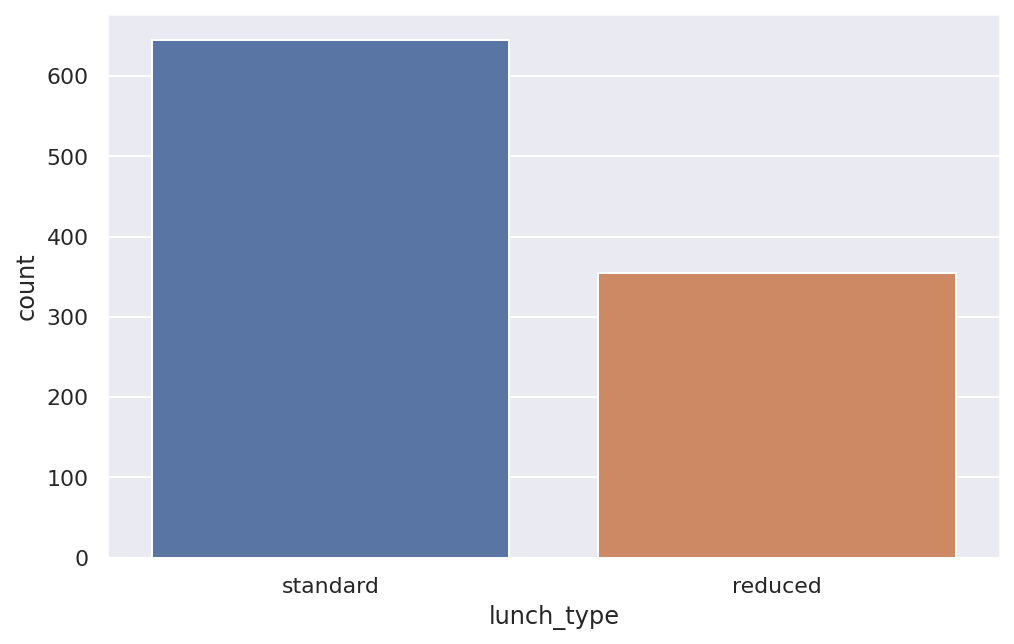

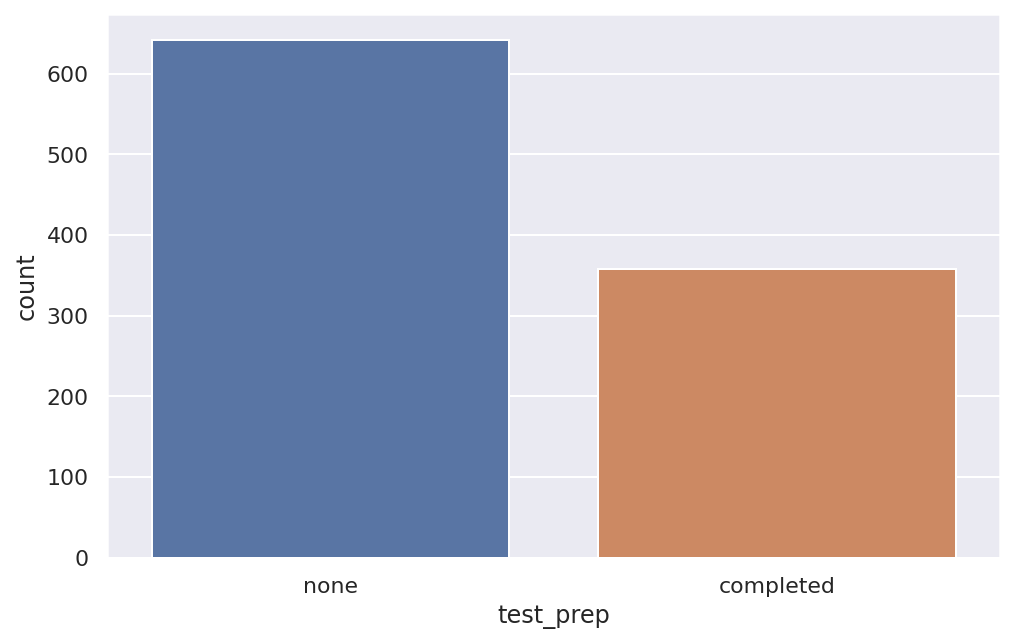

In [22]:
cat_list=['gender','lunch_type','test_prep']
for col in cat_list:
    plt.figure(figsize=(8,5))
    sns.countplot(x=col,data=data)

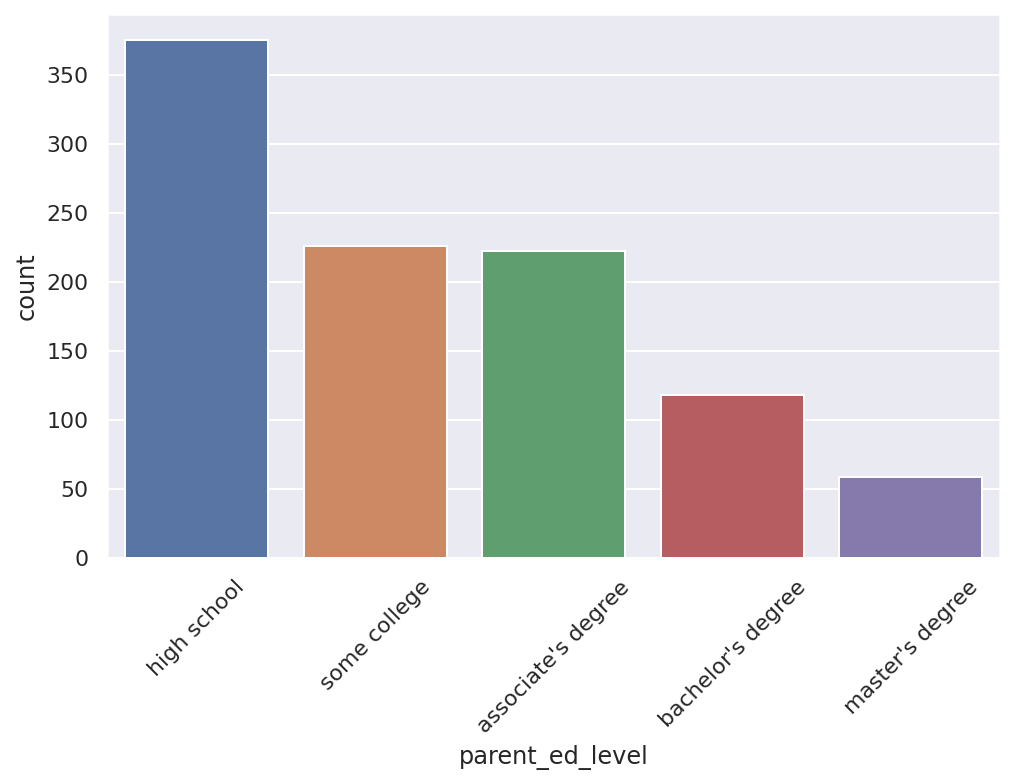

In [23]:
plt.figure(figsize=(8,5))
plt.xticks(rotation=45)
sns.countplot(x='parent_ed_level',data=data,order=['high school','some college',"associate's degree","bachelor's degree","master's degree"])

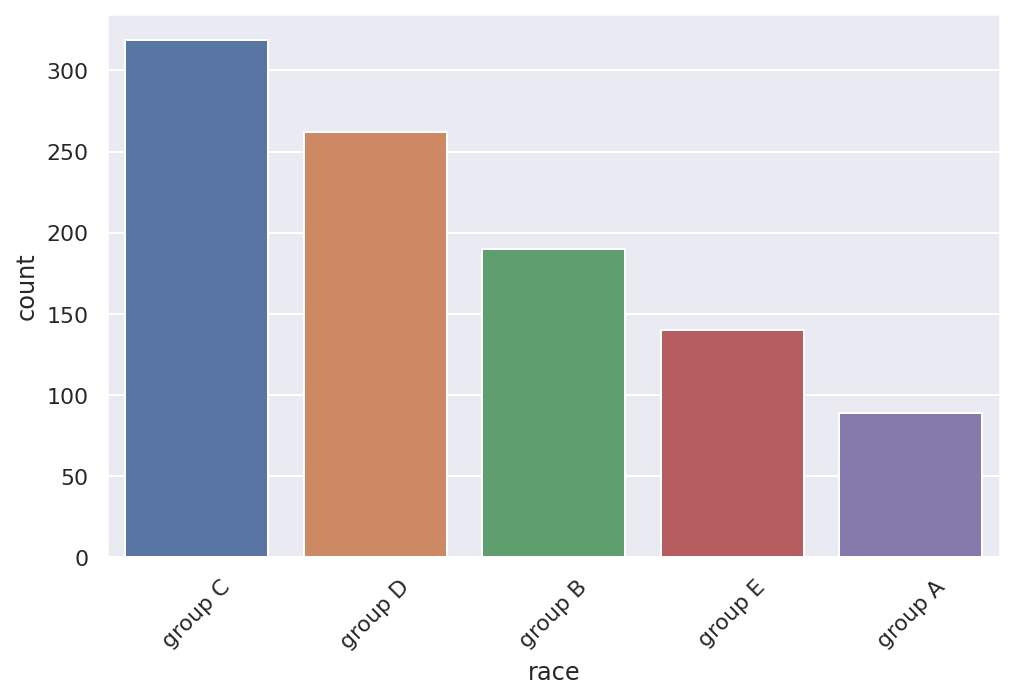

In [24]:
plt.figure(figsize=(8,5))
plt.xticks(rotation=45)
sns.countplot(x='race',data=data,order=['group C','group D',"group B","group E","group A"])

# MULTIVARIATE ANALYSIS

In [25]:
def hue(a,b):
    plt.figure(figsize=(8,5))
    if a=='parent_ed_level':
        plt.xticks(rotation=45)
    sns.countplot(x=a,data=data,hue=b)

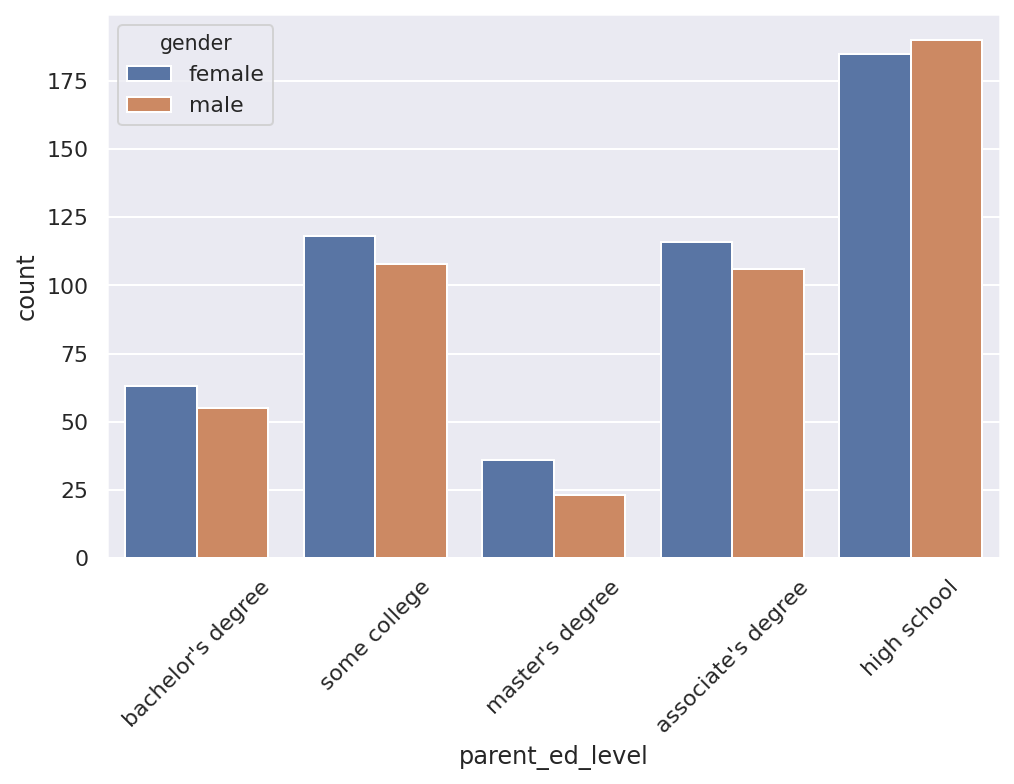

In [26]:
hue('parent_ed_level','gender')

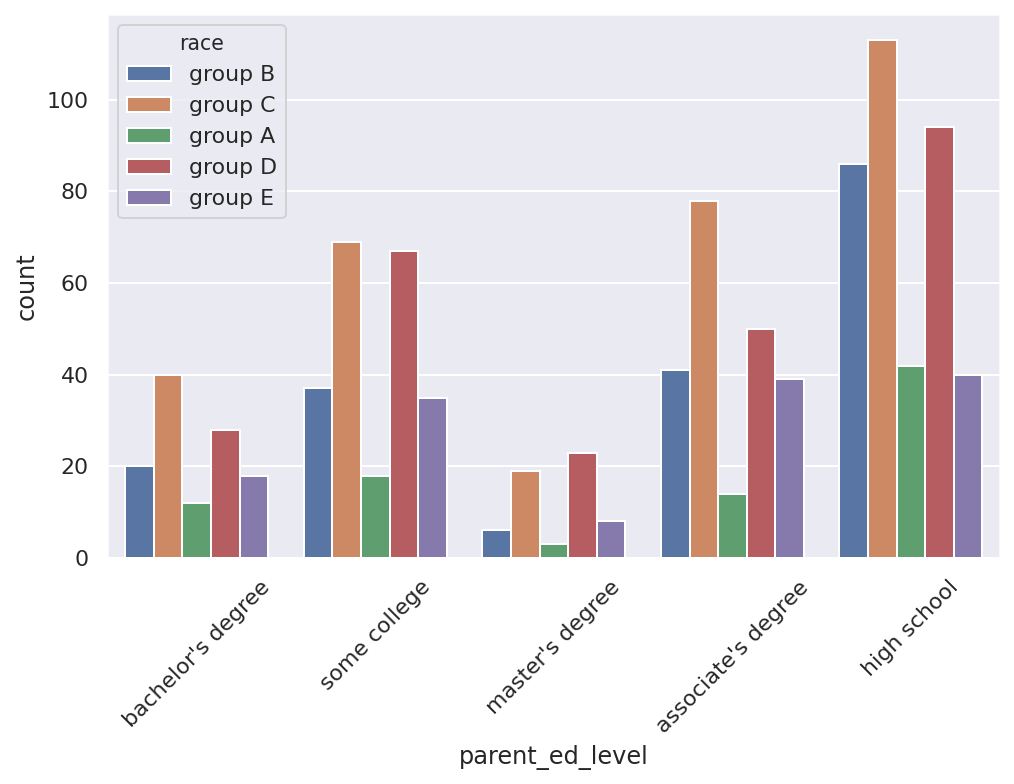

In [27]:
hue('parent_ed_level','race')

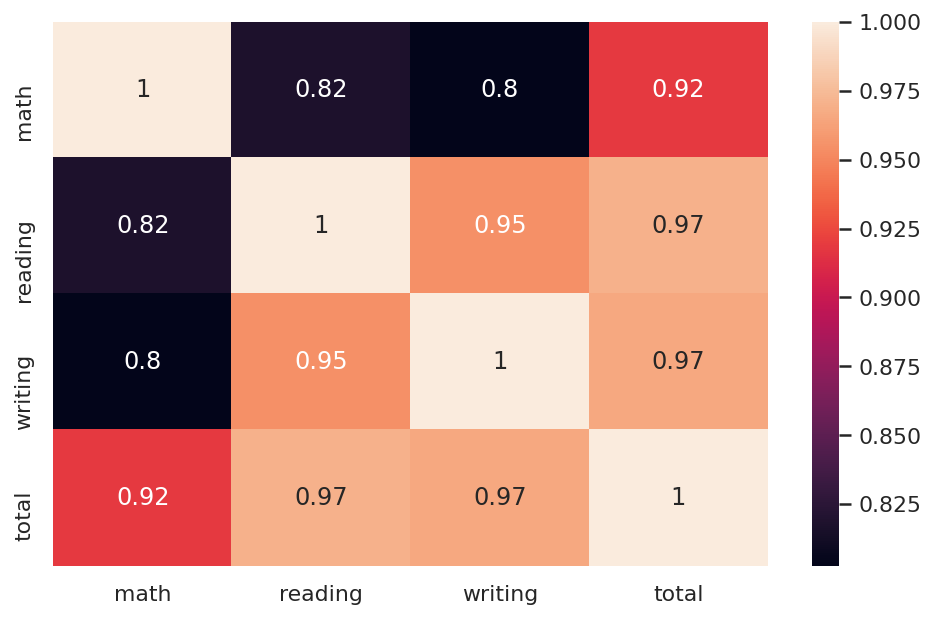

In [28]:
corr_matrix=data[nums].corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr_matrix,annot=True)

Correlation of "total" with "Reading" and "writing" is very high so we drop the total column.

In [29]:
data.drop(['total'],axis=1,inplace=True)

Now for feature engineering and feature selection to predict math score of students, I will create a copy of the original dataset and manipulate features there.

In [30]:
new_data=data.copy()

In [31]:
new_data.drop(['writing'],inplace=True,axis=1)

In [32]:
new_data.head()

,gender,race,parent_ed_level,lunch_type,test_prep,math,reading
0,female,group B,bachelor's degree,standard,none,72,72
1,female,group C,some college,standard,completed,69,90
2,female,group B,master's degree,standard,none,90,95
3,male,group A,associate's degree,reduced,none,47,57
4,male,group C,some college,standard,none,76,78


<Figure size 864x360 with 0 Axes>

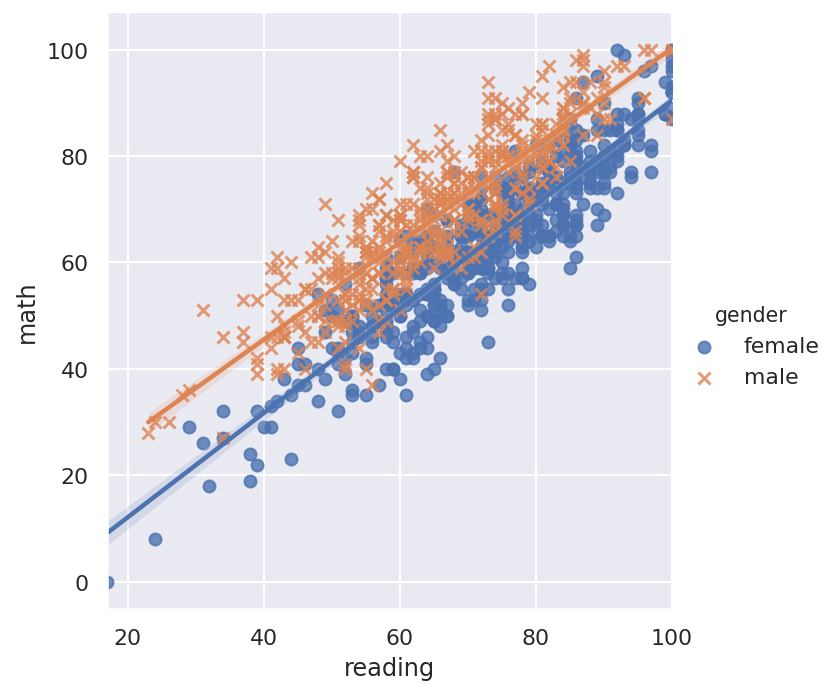

<Figure size 864x360 with 0 Axes>

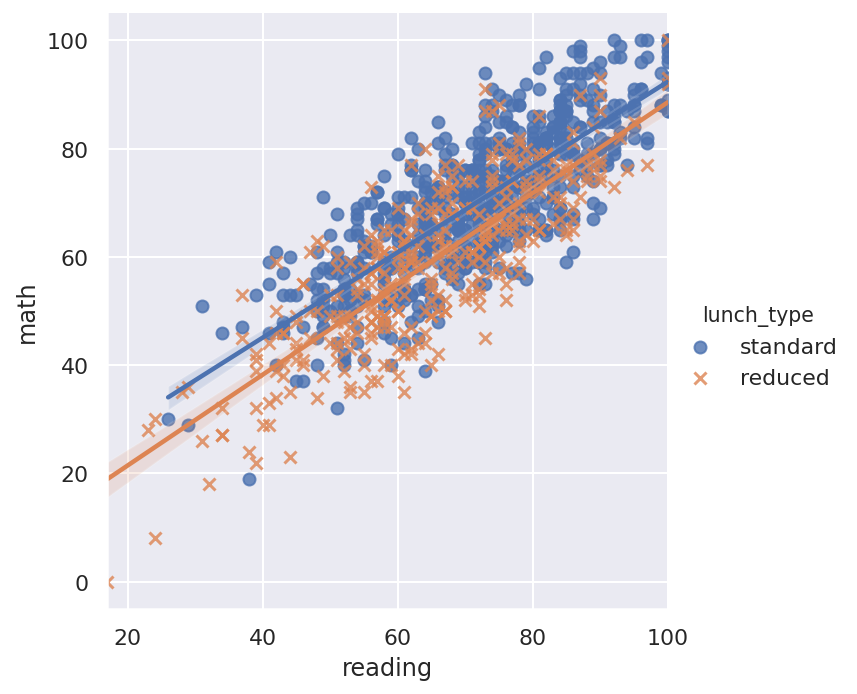

<Figure size 864x360 with 0 Axes>

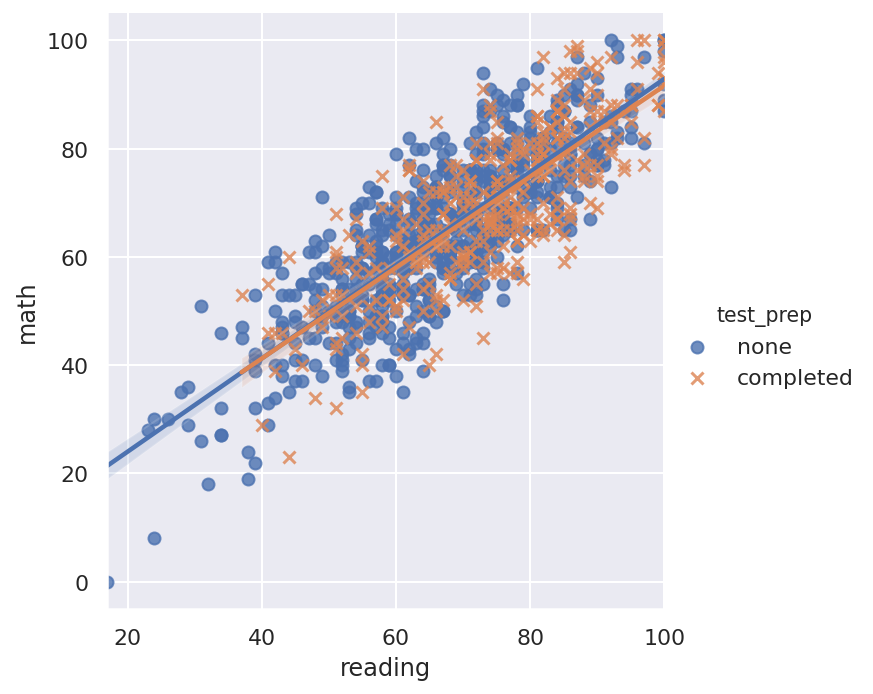

In [33]:
hue_list=['gender','lunch_type','test_prep']
for hue in hue_list:
    plt.figure(figsize=(12,5))
    sns.lmplot(x='reading',y='math',data=new_data,hue=hue,fit_reg=True,markers=['o','x'])

In the scatterplot that has hue parameter set as gender, we can see that male students typically have higher math scores than female students. This could be used to One Hot encode the gender feature later.

Out of the 3 scatterplots with different classification bases, gender and lunch_type seem the most effective on getting a good math score. So I will eliminate test_prep as one of the predicting features and go ahead with gender and lunch_type.

# CHI-SQUARE TEST FOR FEATURE SELECTION

Here we consider two features at a time and test the null hypothesis which assumes that the 2 features are independent against the alternative hypothesis that those 2 features are dependent.

In [34]:
#creating a function to execute chisq test for independence
def chisq(col1,col2):
    #create a contingency table
    table=pd.crosstab(new_data[col1],new_data[col2])
    #get chi_Sq statistics,p-value,degrees of freedom and expected frequencies.
    stat, p, dof, expected = chi2_contingency(table)
    #set significance level
    alpha=0.05
    if p<=0.05:
        print('Features are associated')
    else:
        print('Features are not associated')

In [35]:
chisq('gender','lunch_type')
chisq('gender','parent_ed_level')
chisq('gender','race')
chisq('gender','test_prep')
chisq('lunch_type','test_prep')
chisq('lunch_type','parent_ed_level')
chisq('lunch_type','race')
chisq('parent_ed_level','race')
chisq('parent_ed_level','test_prep')
chisq('race','test_prep')

Features are not associated
Features are not associated
Features are not associated
Features are not associated
Features are not associated
Features are not associated
Features are not associated
Features are not associated
Features are not associated
Features are not associated


Since every pair of categorical features is independent we do not eliminate any of these for our feature selection process.

In [36]:
new_data.drop(['test_prep'],axis=1,inplace=True)

In [37]:
new_data.head()

,gender,race,parent_ed_level,lunch_type,math,reading
0,female,group B,bachelor's degree,standard,72,72
1,female,group C,some college,standard,69,90
2,female,group B,master's degree,standard,90,95
3,male,group A,associate's degree,reduced,47,57
4,male,group C,some college,standard,76,78


Encoding the categorical features

In [38]:
label=LabelEncoder()
cat_list=['gender','race','lunch_type','parent_ed_level']
for col in cat_list:
    new_data[col]=label.fit_transform(new_data[col])

In [39]:
new_data['race'].value_counts()

2    319
3    262
1    190
4    140
0     89
Name: race, dtype: int64

In [40]:
y=new_data['math']
new_data.drop(['math'],axis=1,inplace=True)

In [41]:
new_data['reading']=new_data['reading']/100.0

In [42]:
y=y/100.0

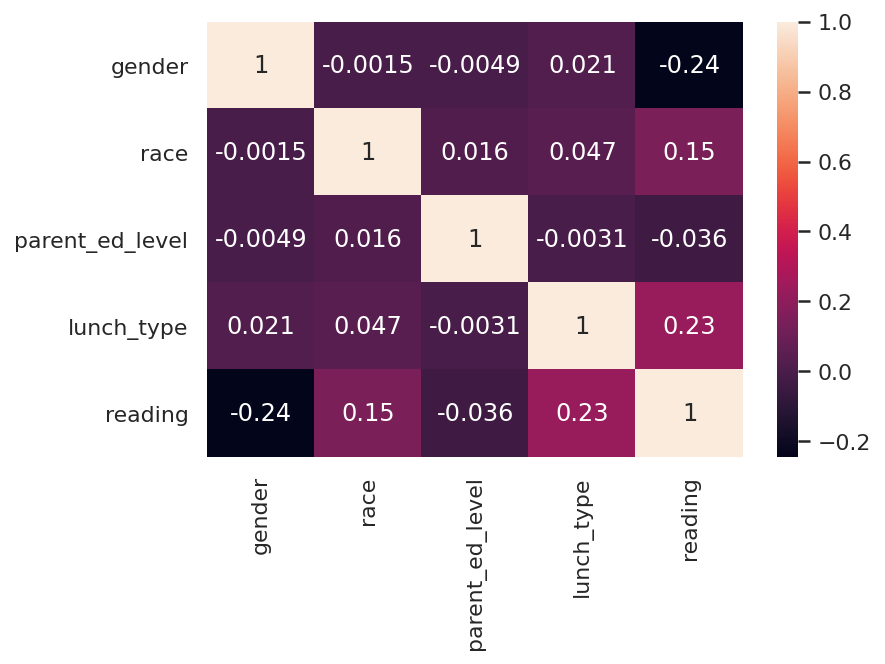

In [43]:
corr_matrix=new_data.corr()
sns.heatmap(corr_matrix,annot=True)

By correlation coefficient we can conclude that there is no high-level of correlation between any of the features.

In [44]:
#creating a function that prints all relevant regression metrics when called
def reg_metrics(actual,predicted):
    mae=metrics.mean_absolute_error(actual,predicted)
    mse=metrics.mean_squared_error(actual,predicted)
    rmse=np.sqrt(metrics.mean_squared_error(actual,predicted))
    r2=r2_score(actual,predicted)
    print("MAE:",mae)
    print("MSE:",mse)
    print("RMSE:",rmse)
    print("R2:",r2)

In [45]:
#creating a function to plot a histogram of the residual values.
def residual_plot(actual,predicted):
    plt.figure(figsize=(10,6))
    plt.xlabel('Residual error value')
    plt.title('Residual Plot',size=13)
    plt.hist(actual-predicted)
#plotting the residual error plot

# LINEAR REGRESSION

In [46]:
#training algorithm with the dataset containing outliers
X_train, X_holdout, y_train, y_holdout = train_test_split(new_data.values,y,test_size=0.3,random_state=17)
reg=LinearRegression(normalize=True)
reg.fit(X_train,y_train)
pred=reg.predict(X_holdout)

In [47]:
coef_df = pd.DataFrame(reg.coef_, new_data.columns, columns=['coefficients'])
coef_df

,coefficients
gender,0.114165
race,0.010506
parent_ed_level,0.001231
lunch_type,0.042006
reading,0.882106


In [48]:
intercept=reg.intercept_
intercept

-0.05805471158456632

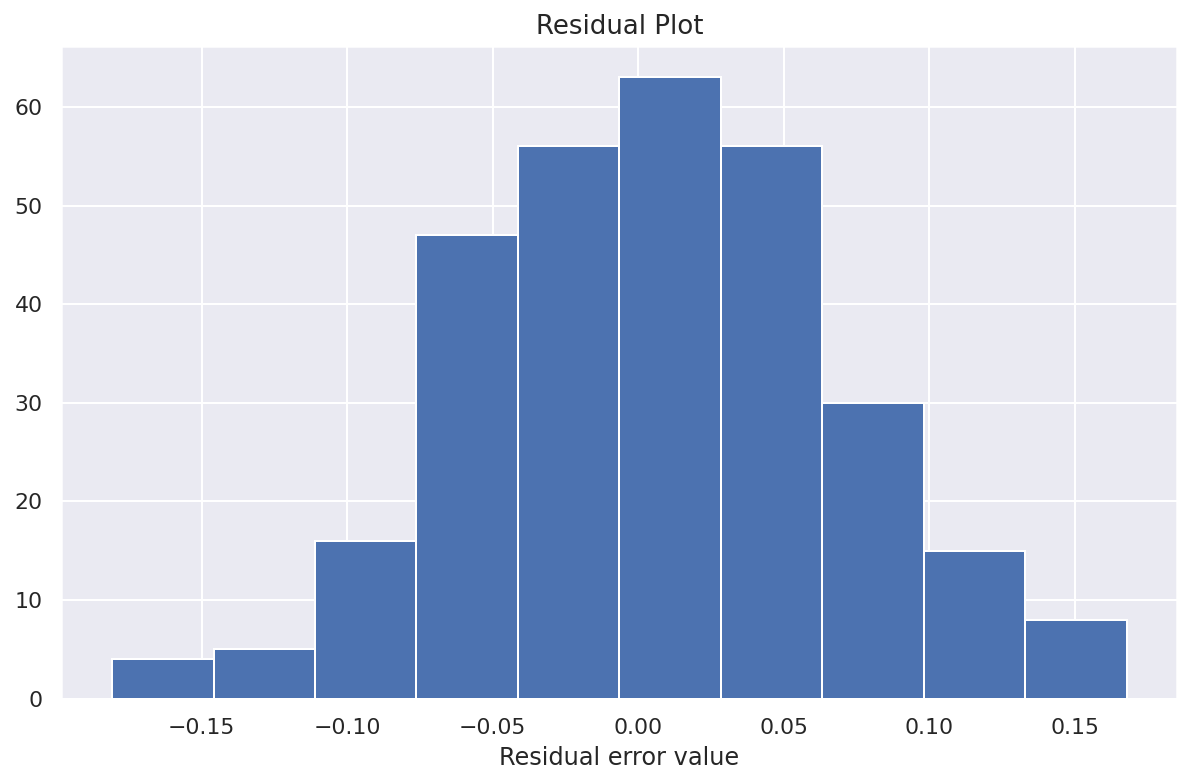

In [49]:
residual_plot(y_holdout,pred)

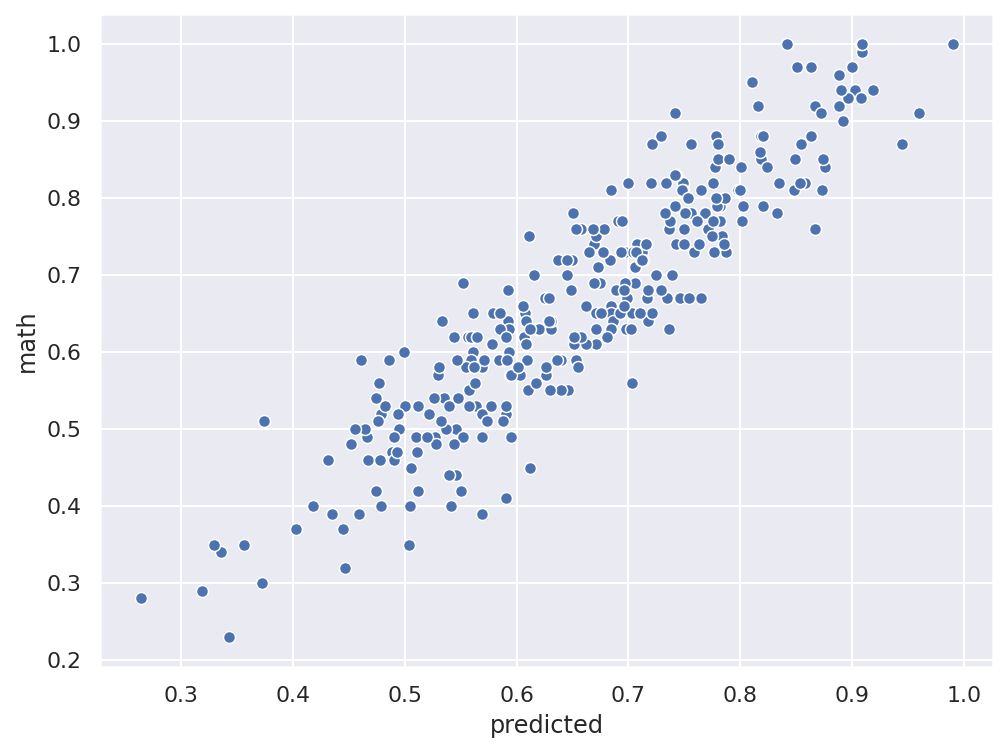

In [50]:
plt.figure(figsize=(8,6))
plt.xlabel('predicted')
plt.ylabel('actual')
sns.scatterplot(pred,y_holdout)

In [51]:
reg_metrics(y_holdout,pred)

MAE: 0.051054370806356546
MSE: 0.004043699097831908
RMSE: 0.0635900864744805
R2: 0.8336765595537288


Defining the metrics obtained above:

1) MAE is just the Mean Absolute Error, ie the mean of residual errors mathematically given by sum(abs(Y(actual)-Y(pred)))/no.of predictions

2) MSE is the Mean Square Error, ie the square of the MAE.

3) RMSE is the square root of MSE.

4) R2 score returns a value that tells you how much of the variation in the target variable has been captured by the features used to predict said target variable.

# RIDGE REGRESSION

CROSS VALIDATION ON THE TRAINING DATASET TO DETERMINE ALPHA VALUE

In [52]:
ridge=Ridge()
cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid=dict()
grid['alpha']=np.arange(0.0,1.0,0.01)
search=GridSearchCV(ridge, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1,refit=False)
result=search.fit(X_train,y_train)
print('MAE: %.3f' % result.best_score_)
print('Config: %s' % result.best_params_)

MAE: -0.048
Config: {'alpha': 0.04}


The best evaluation metrics for predicting marks would be the MAE because a student's grade in any subject can change by even 1 mark. So we will consider MAE and RMSE to be our top priorities to ensure closest possible predictions

In [53]:
ridge=Ridge(alpha=0.04)
ridge.fit(X_train,y_train)
pred1=ridge.predict(X_holdout)
reg_metrics(y_holdout,pred1)

MAE: 0.05109392129629646
MSE: 0.004049491584354413
RMSE: 0.06363561569085674
R2: 0.8334383058499163


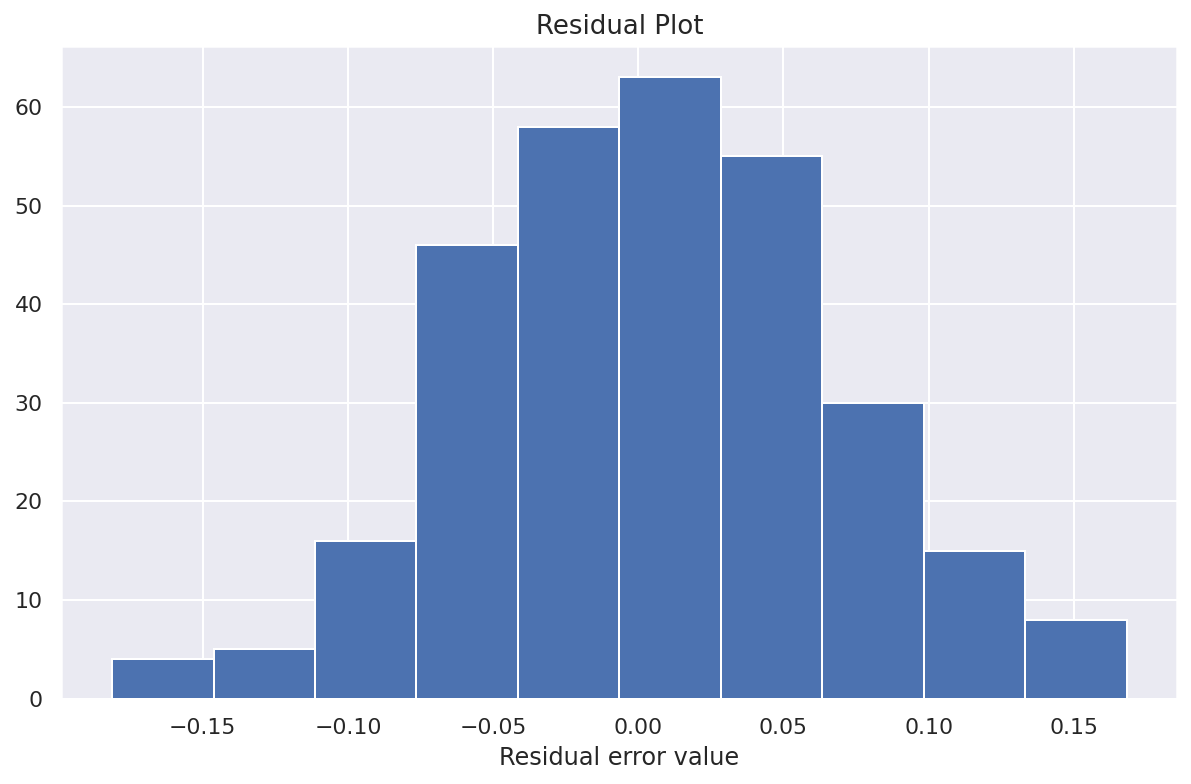

In [54]:
residual_plot(y_holdout,pred1)

The Ridge regression model performed slightly worse than the Linear regression model.

# LASSO REGRESSION

In [55]:
lasso=Lasso(normalize=True)
cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid=dict()
grid['alpha']=np.arange(0.0,2.0,0.01)
search=GridSearchCV(lasso,grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1,refit=False)
result=search.fit(X_train,y_train)
print('MAE: %.3f' % result.best_score_)
print('Config: %s' % result.best_params_)


MAE: -0.060
Config: {'alpha': 0.0}


In [56]:
lasso=Lasso(normalize=True,alpha=0)
lasso.fit(X_train,y_train)
pred2=lasso.predict(X_holdout)
reg_metrics(y_holdout,pred2)

MAE: 0.051054370806356546
MSE: 0.004043699097831909
RMSE: 0.06359008647448051
R2: 0.8336765595537288


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning:

Coordinate descent with no regularization may lead to unexpected results and is discouraged.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2585066967277234, tolerance: 0.0015674762714285714



Lasso and Ridge regression performed slightly worse than the Linear Regression model. Hence I choose my Linear Regression model to predict future unseen data. It manages to explain around 84% of the variance in the data with a MAE of around 5 marks.

Updations will be made to the notebook.

# **RANDOM FOREST REGRESSOR**

In [57]:
from sklearn.ensemble import RandomForestRegressor

In [58]:
forest=RandomForestRegressor(n_estimators=100)
forest.fit(X_train,y_train)
pred3=forest.predict(X_holdout)
reg_metrics(y_holdout,pred3)

MAE: 0.057582238492063474
MSE: 0.005187352899855296
RMSE: 0.07202328026308782
R2: 0.7866363544271959


Without applying techniques to improve the regressor model, the RandomForest regressor performs worse than the Lasso and Linear regression models, giving an MAE of about 5.7 marks and an R2 score of 0.786.

I will now apply GridSearchCV to figure out the best parameters to predict Math score.

In [59]:
from sklearn.model_selection import GridSearchCV

In [60]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [3,4,5],
    'max_features': [3,4,5],
    'min_samples_leaf': [3,4,5],
    'min_samples_split': [8,10],
    'n_estimators': [100, 200]
}
forest_cv=RandomForestRegressor(criterion='mae')
# Instantiate the grid search model
grid=GridSearchCV(estimator=forest_cv, param_grid=param_grid, cv=6, n_jobs=-1, verbose=2)

In [61]:
grid.fit(X_train,y_train)

Fitting 6 folds for each of 108 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  2.6min finished


GridSearchCV(cv=6, estimator=RandomForestRegressor(criterion='mae'), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [3, 4, 5],
                         'max_features': [3, 4, 5],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10],
                         'n_estimators': [100, 200]},
             verbose=2)

In [62]:
grid.best_params_

{'bootstrap': True,
 'max_depth': 5,
 'max_features': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

In [63]:
forest_cv=RandomForestRegressor(criterion='mae',bootstrap=True,max_depth=5,max_features=4,min_samples_leaf=3,min_samples_split=10,n_estimators=100)
forest_cv.fit(X_train,y_train)
pred4=forest_cv.predict(X_holdout)

In [64]:
reg_metrics(y_holdout,pred4)

MAE: 0.05417050000000001
MSE: 0.004475005258333334
RMSE: 0.06689548010391534
R2: 0.8159362869061593


As we can see,Hyperparameter tuning improved the performance of the model on unseen data. But it is still slightly better in performance than Linear regression. 

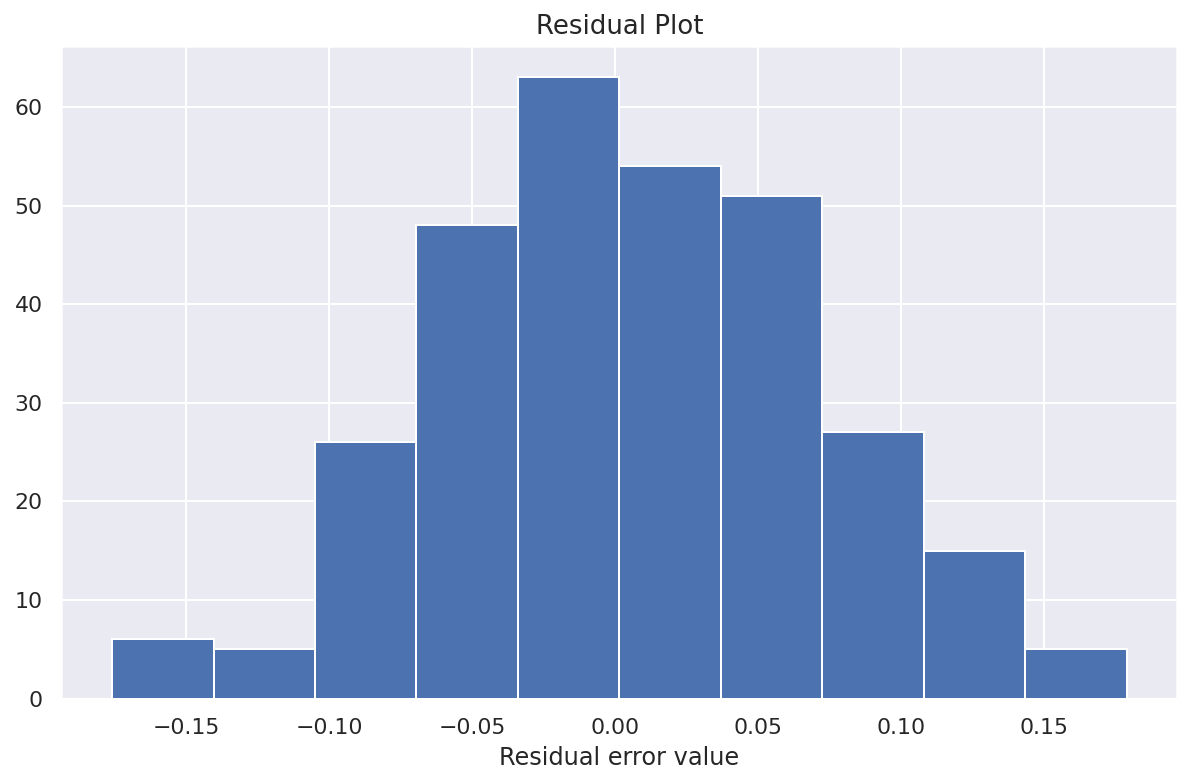

In [65]:
residual_plot(y_holdout,pred4)

# ONE HOT ENCODING CATEGORICAL FEATURES.


In [74]:
X1_train, X1_holdout, y1_train, y1_holdout = train_test_split(new_data,y,test_size=0.3,random_state=17)

In [69]:
from sklearn.preprocessing import OneHotEncoder

In [77]:
ohe=OneHotEncoder(sparse=False,handle_unknown='ignore')
OH_cols_train = pd.DataFrame(ohe.fit_transform(X1_train[['gender']]))
OH_cols_holdout = pd.DataFrame(ohe.transform(X1_holdout[['gender']]))

OH_cols_train.index = X1_train.index
OH_cols_holdout.index = X1_holdout.index

num_X_train = X1_train.drop(['gender'], axis=1)
num_X_holdout = X1_holdout.drop(['gender'], axis=1)

OH_X_train = pd.concat([num_X_train, OH_cols_train],axis=1)
OH_X_holdout = pd.concat([num_X_holdout, OH_cols_holdout],axis=1)

# LINEAR REGRESSION IN ONE-HOT ENCODED DATASET

In [80]:
reg_ohe=LinearRegression(normalize=True)
reg_ohe.fit(OH_X_train,y_train)
pred_ohe=reg_ohe.predict(OH_X_holdout)

In [81]:
reg_metrics(y_holdout,pred_ohe)

MAE: 0.05105437080635656
MSE: 0.004043699097831911
RMSE: 0.06359008647448053
R2: 0.8336765595537287


# RANDOM FOREST REGRESSOR ON ONE HOT ENCODED DATA

In [84]:
forest_ohe=RandomForestRegressor(n_estimators=100)
forest_ohe.fit(OH_X_train,y_train)
pred_ohe1=forest_ohe.predict(OH_X_holdout)
reg_metrics(y_holdout,pred_ohe1)

MAE: 0.057614586544011505
MSE: 0.005173090147128217
RMSE: 0.07192419722964044
R2: 0.787223002950345


Hyperparameter tuning:


In [88]:
param_grid_ohe = {
    'bootstrap': [True],
    'max_depth': [4,5],
    'max_features': [4,5,6],
    'min_samples_leaf': [3,4,5],
    'min_samples_split': [8,10],
    'n_estimators': [100, 200]
}
forest_cv_ohe=RandomForestRegressor(criterion='mae')
# Instantiate the grid search model
grid_ohe=GridSearchCV(estimator=forest_cv_ohe, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

In [89]:
grid_ohe.fit(OH_X_train,y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  2.0min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(criterion='mae'), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [3, 4, 5],
                         'max_features': [3, 4, 5],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10],
                         'n_estimators': [100, 200]},
             verbose=2)

In [90]:
grid_ohe.best_params_

{'bootstrap': True,
 'max_depth': 5,
 'max_features': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 100}

In [92]:
for_cv_ohe=RandomForestRegressor(bootstrap=True,max_depth=5,max_features=5,min_samples_leaf=4,min_samples_split=10,n_estimators=100)
for_cv_ohe.fit(OH_X_train,y_train)
pred6=for_cv_ohe.predict(OH_X_holdout)
reg_metrics(y_holdout,pred6)

MAE: 0.05436457458673401
MSE: 0.0045070281590170284
RMSE: 0.06713440369152786
R2: 0.8146191367211624


In both cases gridsearch has improved model performance but still Linear regression gives the maximum R2 score and the least MAE.

CONCLUSION: LINEAR REGRESSION MODEL WILL BE USED TO MAKE PREDICTIONS OF MATH SCORE OF STUDENTS